In [ ]:
# import libraries
import scanpy as sc
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def discover_new_annotations(data, clustering_resolution=0.8, n_pcs=50):
    """
    Discovers new cell annotations using clustering algorithms and UMAP visualization.

    Parameters:
    - data: AnnData object containing single-cell gene expression data.
    - clustering_resolution: Resolution for Leiden clustering (higher values create more clusters).
    - n_pcs: Number of principal components for dimensionality reduction.

    Returns:
    - data: Annotated AnnData object with new clusters in `data.obs["discovered_clusters"]`.
    """
    # Preprocess data
    sc.pp.pca(data, n_comps=n_pcs)
    sc.pp.neighbors(data, use_rep="X_pca")

    # Perform clustering
    sc.tl.leiden(data, resolution=clustering_resolution)  # Leiden clustering algorithm
    data.obs["discovered_clusters"] = data.obs["leiden"]  # Save clusters to new column

    # Compute UMAP
    sc.tl.umap(data)

    print("Clusters discovered and annotated.")
    return data


In [ ]:
# Visualize clusters using UMAP
def visualize_clusters_on_umap(data, cluster_column="discovered_clusters"):
    """
    Visualizes discovered clusters on a UMAP plot.

    Parameters:
    - data: AnnData object containing UMAP coordinates and clusters.
    - cluster_column: Column name containing cluster information.

    Returns:
    - fig: Plotly UMAP visualization.
    """
    umap_df = pd.DataFrame(data.obsm["X_umap"], columns=["UMAP1", "UMAP2"])
    umap_df[cluster_column] = data.obs[cluster_column].values

    fig = px.scatter(
        umap_df,
        x="UMAP1",
        y="UMAP2",
        color=cluster_column,
        title="UMAP with Discovered Clusters",
        labels={cluster_column: "Cluster"},
    )
    fig.update_traces(marker=dict(size=5, opacity=0.8))
    return fig


In [ ]:
# Visualize gene expression in clusters using a bubble plot
def plot_bubble_matrix(adata, cluster_column="discovered_clusters", top_n_genes=10):
    # Get the cluster labels
    clusters = adata.obs[cluster_column].unique()

    # Extract the marker genes (use the most variable genes or any list you prefer)
    marker_genes = adata.var_names[:top_n_genes]

    # Collect the gene expression for each cluster
    cluster_expression = []
    for cluster in clusters:
        # Get the subset of cells belonging to the current cluster
        cluster_cells = adata[adata.obs[cluster_column] == cluster]

        # Get the average expression for each marker gene
        mean_expression = cluster_cells[:, marker_genes].X.mean(axis=0)  # Make sure it's 2D
        cluster_expression.append(mean_expression.A1 if hasattr(mean_expression, "A1") else mean_expression)

    # Convert cluster_expression to a 2D numpy array
    cluster_expression = np.array(cluster_expression)

    # Create a DataFrame for the cluster expression matrix
    bubble_df = pd.DataFrame(
        cluster_expression,
        columns=marker_genes,
        index=adata.obs[cluster_column].unique(),
    )

    bubble_df.index.name = "Cluster"
    bubble_df = bubble_df.reset_index().melt(id_vars="Cluster", var_name="Gene", value_name="Expression")

    # Plotting the bubble plot
    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(
        data=bubble_df,
        x="Gene",
        y="Cluster",
        size="Expression",
        hue="Expression",
        palette="viridis",
        sizes=(50, 500),
        marker="o",
    )

    # Adjust the legend position to the right side
    plt.legend(title="Expression", bbox_to_anchor=(1.05, 0.5), loc="center left")

    # Title and label adjustments
    plt.title("Gene Expression in Clusters")
    plt.xticks(rotation=90)
    plt.tight_layout()  # Ensure the plot fits within the figure space

    # Show the plot
    plt.show()


/Users/jaydeepbhat/Documents/Hackathon/2024_AI_Agent/scripts/talk2cells/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/vn/z_dtm8w13b92pwg7wrgkkfx00000gn/T/ipykernel_56284/3840506039.py:26: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(data, resolution=clustering_resolution)  # Leiden clustering algorithm


Clusters discovered and annotated.


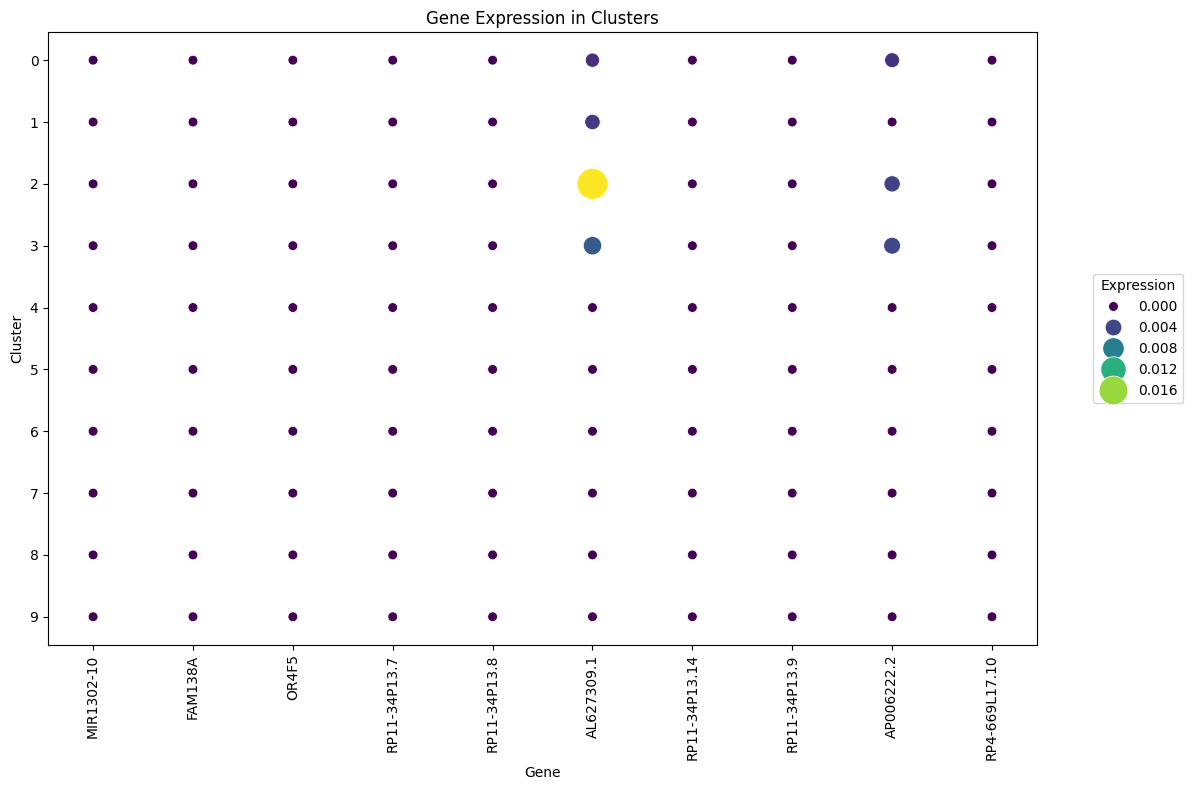

In [ ]:
# Example Usage
if __name__ == "__main__":
    # Load example single-cell data
    adata = sc.datasets.pbmc3k()  # Example PBMC dataset
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # Discover new clusters
    adata = discover_new_annotations(adata, clustering_resolution=0.8, n_pcs=50)

    # Visualize discovered clusters on UMAP
    fig = visualize_clusters_on_umap(adata, cluster_column="discovered_clusters")
    fig.show()

    # Visualize gene expression in clusters using a bubble plot
    plot_bubble_matrix(adata, cluster_column="discovered_clusters", top_n_genes=10)
